In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#Matrix operations
from itertools import product


# Forward simulation

### Variables

In [83]:
alpha = 0.5
nodes = [7, 8, 1, 10, 6, 9, 3, 5, 11, 4, 2]
parents_top = [[], [], [7, 8], [7], [7,10], [10,6], [9,8], [9,8], [9,8], [11, 8, 9], [4, 8]]

# Switch the from topological order to index order
def node_to_index(nodes, parents):
    reordered_parents = [-1] * (max(nodes) + 1)
    for node, parent in zip(nodes, parents):
        reordered_parents[node] = parent
    return reordered_parents[1:max(nodes)+1]
parents = node_to_index(nodes, parents_top)
parents.insert(0, -1)

print(nodes)
print(parents)

[7, 8, 1, 10, 6, 9, 3, 5, 11, 4, 2]
[-1, [7, 8], [4, 8], [9, 8], [11, 8, 9], [9, 8], [7, 10], [], [], [10, 6], [7], [9, 8]]


### Genereate cpd's

In [84]:
def synthetic_cpd(alpha, parent):
    # Create all possible combinations of parent values
    df = pd.DataFrame(list(product([0, 1], repeat=len(parent))), columns=parent)
    df['prob'] = 1 - alpha ** (1 + df.sum(axis=1)) # P(X=1|parents)
    return df

df_x7 = synthetic_cpd(alpha, parents[7])
df_x8 = synthetic_cpd(alpha, parents[8])
df_x1 = synthetic_cpd(alpha, parents[1])
df_x10 = synthetic_cpd(alpha, parents[10])
df_x6 = synthetic_cpd(alpha, parents[6])
df_x9 = synthetic_cpd(alpha, parents[9])
df_x3 = synthetic_cpd(alpha, parents[3])
df_x5 = synthetic_cpd(alpha, parents[5])
df_x11 = synthetic_cpd(alpha, parents[11])
df_x4 = synthetic_cpd(alpha, parents[4])
df_x2 = synthetic_cpd(alpha, parents[2])

print(df_x1[(df_x1[7] == 1) & (df_x1[8] == 1)]['prob'].values)


[0.875]


### Helper functions

In [85]:
# condition = (df_x1[8] == 1).values
# print(condition)
def get_parrents(df : pd.DataFrame) -> list:
    return [col for col in df.columns if not str(col).startswith('prob')]

# df -> The conditional probability table
# state -> The state of the parents true/false
# returns -> The probability of the state
    # It's important that the state is given in the same order  as the columns of the dataframe.
def return_probability(df : pd.DataFrame, state : list) -> int:
    #Index of all columns that are not the probability
    parents = [col for col in df.columns if not str(col).startswith('prob')]
    # print(parents)
    # Table where the row 
    condition = (df[parents] == state).all(axis=1)
    # Get the probability of the condition
    matching_probabilities = df.loc[condition, 'prob'] # returns the row where the condition is true
    matching_probabilities = matching_probabilities.values # single value list

    return matching_probabilities[0]

print(return_probability(df_x1, [0,0]))



0.5


### Simulate

In [86]:
def simulate_binomial(nodes, print_outcomes = False):
    # Simulate
    X7, X8 = np.random.binomial(n=1, p=df_x7['prob']), np.random.binomial(n=1, p=df_x8['prob'])
    X7, X8 = X7[0], X8[0] # We want the value as an integer, not a list

    p_x1 = return_probability(df_x1, [X7, X8])
    X1 = np.random.binomial(n=1, p=p_x1)

    p_x10 = return_probability(df_x10, [X7])
    X10 = np.random.binomial(n=1, p=p_x10)

    p_x6 = return_probability(df_x6, [X7, X10])
    X6 = np.random.binomial(n=1, p=p_x6)

    p_x9 = return_probability(df_x9, [X10, X6])
    X9 = np.random.binomial(n=1, p=p_x9)

    p_x3 = return_probability(df_x3, [X9, X8])
    X3 = np.random.binomial(n=1, p=p_x3)

    p_x5 = return_probability(df_x5, [X9, X8])
    X5 = np.random.binomial(n=1, p=p_x5)

    p_x11 = return_probability(df_x11, [X9, X8])
    X11 = np.random.binomial(n=1, p=p_x11)

    p_x4 = return_probability(df_x4, [X11, X8, X9])
    X4 = np.random.binomial(n=1, p=p_x4)

    p_x2 = return_probability(df_x2, [X4, X8])
    X2 = np.random.binomial(n=1, p=p_x2)

    if print_outcomes:
        print('Simulating')
        print('(X7, p) = ', ((X7, df_x7['prob'][0])), 'pa = ', get_parrents(df_x7)) 
        print('(X8, p) = ', ((X8, df_x8['prob'][0])), 'pa = ', get_parrents(df_x8))
        print('(X1, p) = ', ((X1, p_x1)), 'pa = ', get_parrents(df_x1))
        print('(X10, p) = ', ((X10, p_x10)), 'pa = ', get_parrents(df_x10))
        print('(X6, p) = ', ((X6, p_x6)), 'pa = ', get_parrents(df_x6))
        print('(X9, p) = ', ((X9, p_x9)), 'pa = ', get_parrents(df_x9))
        print('(X3, p) = ', ((X3, p_x3)), 'pa = ', get_parrents(df_x3))
        print('(X5, p) = ', ((X5, p_x5)), 'pa = ', get_parrents(df_x5))
        print('(X11, p) = ', ((X11, p_x11)), 'pa = ', get_parrents(df_x11))
        print('(X4, p) = ', ((X4, p_x4)), 'pa = ', get_parrents(df_x4))
        print('(X2, p) = ', ((X2, p_x2)), 'pa = ', get_parrents(df_x2))
    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]


simulate_binomial(nodes, True)

Simulating
(X7, p) =  (1, 0.5) pa =  []
(X8, p) =  (1, 0.5) pa =  []
(X1, p) =  (1, 0.875) pa =  [7, 8]
(X10, p) =  (1, 0.75) pa =  [7]
(X6, p) =  (1, 0.875) pa =  [7, 10]
(X9, p) =  (0, 0.875) pa =  [10, 6]
(X3, p) =  (1, 0.75) pa =  [9, 8]
(X5, p) =  (1, 0.75) pa =  [9, 8]
(X11, p) =  (1, 0.75) pa =  [9, 8]
(X4, p) =  (1, 0.875) pa =  [11, 8, 9]
(X2, p) =  (1, 0.875) pa =  [4, 8]


[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

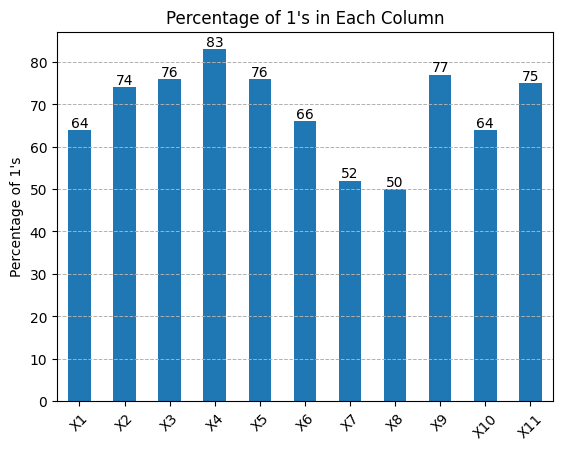

In [87]:
def forward(alpha, n):
    lst = []
    for elm in range(0, n):
        lst.append(simulate_binomial(nodes))
    df=pd.DataFrame(lst,columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11'])
    return(df)

# Calculate the percentage of 1's for each column
percentages = forward(0.5, 100).mean() * 100  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage

# Plotting
fig, ax = plt.subplots()
percentages.plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel('Percentage of 1\'s')
ax.set_title('Percentage of 1\'s in Each Column')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)  # Add gridlines for better readability
plt.show()